

# Variational method for image restoration with L1 regression in wavelet space

## Jérémy Scanvic and Afsin Ozdemir 

### Optimization Lecture Project 

# Introduction 
Imagine denoising has an important role in image processing, first reason can be seen as the problems happening because of physical the environment, data transmission and several more reasons noise the images during the process. In our project we worked into a specific type of image denoising approach, which is called "variational denoising method/s". In the following part, first we will going to explain, what is the form of the problem and which form do we concern.

## General Problem
The method of variational approach, for the known image $x$, and the denoised image $y$, which us $y = \bar{x} +\varepsilon$, where we represent the noise as $\varepsilon$. which can contribute different distributions, mainly we will assume that $\varepsilon \sim N(0,1)$. The raw version of the problem is the following, 
$$
\text{argmin}_{z \in \mathbb{R}^N} \frac{1}{2} ||y - x ||^{2}_{2} + \lambda R(x)
$$
Here key is to find appropriate regularization term $R(x)$.
## Regularization Term
### Wavelet Transform
The problem which we will explain the different aspects has a special form. We have chosen $R(x) = ||W x||_1$, where $W x$ represent the wavelet transformation of the image x, and $||\cdot||_{1}$ is $L^1$ norm as usual. Also, we dealt with the blurred image $\phi x$, which we are in the position that we know the $\phi$, or as we can call the blur kernel, for the sake of simplicity (and mainly convexity). So, we mainly solved the following problem, 

\begin{equation}
\text{argmin}_{z \in \mathbb{R}^N} \frac{1}{2} ||\phi x - z ||^{2}_{2} + \lambda||Wx||_{1}.
\end{equation}

# Objective

Our objective is to solve the above problem numerically by using the tools that were seen in the lectures and comparing the outputs of different algorithms, by looking at their efficiency with different factor. For the sake of simplicity we are not going to give all the definitions until it's needed. 

# Choice of Algorithms

We can see the problem we have previously as in the following form, 
$$
\text{argmin}_{x \in \mathbb{R}^N} f(x) + (g \circ L)(x)
$$
where $f(x) = \frac{1}{2} ||\phi x - z ||^{2}_{2}$, $g(x) = ||\cdot||_{1} $ and $L x = W x$
We will implement several algorithms some of them listed below, 
- Forward Backward 
- Douglas-Rachford
- ADMM
- Condat-Vū
- (maybe the others)

However, our cases would consider only the Condat-Vū algorithm, which will be explained later, by comparison of the outputs with different regularization terms and result of ADAM.

# Calculations
For the Condat-Vū algorithm as a chosen one before we need to calculate several operator of the functions, they are 
- $\nabla f$
- $\text{prox}_{f}$
- $\text{prox}_{g}$

**First differential of $f$:**
***

Which is well-known,$\nabla f = \phi^{*}|\phi x - z|$

**Proximal operator of $f$:**
***
$$\begin{align*}
prox_{f}(v) &=  argmin_{x \in \mathbb{F}^{n}} f(x) + ||x-v||_{2}^{2}\\
&= argmin_{x \in \mathbb{F}^{n}}  ||\Phi x - z||_{2}^{2} + ||x-v||_{2}^{2}
\end{align*}
$$
Let $\hat{x}$ be the minimum argument, so it should be equal to
$$
\begin{align*}
\hat{x} &= (\phi^{*}\phi + I)^{-1}(\phi^{*}z+ v)
\end{align*}
$$

**Proximal operator of $g$:**
*** 
For the function $g$, proximal operator is well known. 
$$
\text{prox}_{\gamma g} (u) = \left( \text{soft}_{[-\gamma,\gamma]}(x_k)\right)_{1\leq k \leq N}
$$
where the soft function defines as; 
$$
\text{soft}_{[-\gamma,\gamma]}(x) = \begin{cases}  x+\gamma & \text{  if  }x < -\gamma\\
 0 & \text{  if  } -\gamma \leq x \leq \gamma \\
 x - \gamma & \text{  if  } x > \gamma 
 \end{cases}
$$


## Metrics of Denoising Performance 
### Peak Signal Noise Ratio
Peak Signal Noise Ratio, shortly, PSNR is n signal processing method that look at the ratio of maximum possible power of the signal and the power of the computing noise that affects the fidelity of its representation.//
It defined via mean square error(MSE), which is defined for $ m\times n $ image $X$ and its approximation $\hat{X}$ as 
$$
MSE = \frac{1}{mn}\sum_{i=0}^{m-1} \sum_{j=0}^{n-1} [X(i,j)-\hat{X}(i,j)]^2
$$
and PSNR in decibel (dB) is defined as, 
$$
\begin{align*}
\text{PSNR} &= 10 \log_{10} \left(\frac{\text{MAX}_{\text{I}}^2}{\text{MSE}}\right)\\
%& = 20.\log_{10}\left(\frac{\text{MAX}}{\sqrt{\text{MSE}}}\right)\\
%& = 20.\log{10}(\text{MAX}_{\text{I}}) - 10.\log{10}(\text{MSE})
\end{align*}
$$
Note that high PSNR means high performance for the image (in general signal) processing.

### Structural Similarities 
The structural similarity index measure (SSIM) is a method for predicting the perceived quality of digital television and cinematic pictures, as well as other kinds of digital images and videos. Mathematical formula of it is unnecessary and long for right now, however notes that, its values changing between $(0,1)$ and closing $1$ means more structural similarity, high performance. 



# Implementations
## Preperation
In case of the reader does not have the following packages, we recommend them to download it with the following comments. The package `einops` is to have a good good organization of the code, and we will use `torchmetrics` to have comparison metrics such as PSNR and SSIM.

In [1]:
!pip install einops 
!pip install torchmetrics 

In [2]:
import torch 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pywt
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics.functional import structural_similarity_index_measure as ssim 
from skimage.io import imread
from einops import rearrange, repeat

Here we have the all the packages that it used, except the most known ones, here is couple of explanations:
- `pywt` is a package that contain the wavelets transform tools as a `numpy` vectors. 
- `pyshearlab` is a package that contains the shearlet transform tools as a `numpy` vectors.

First lets get the popular image "lena.png" by following

In [3]:
# download lena.png
!wget https://raw.githubusercontent.com/mikolalysenko/lena/master/lena.png -O lena.png

--2023-01-08 21:25:38--  https://raw.githubusercontent.com/mikolalysenko/lena/master/lena.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘lena.png’

lena.png            100%[===================>] 462,73K  --.-KB/s    in 0,04s   

2023-01-08 21:25:38 (10,4 MB/s) - ‘lena.png’ saved [473831/473831]



## Original image
We want to sure that the image "lena.png" is compatible with our environment.

In [4]:
# numpy.ndarray (512, 512, 3) uint8
x_orig = imread("./lena.png")
# torch.Tensor (512, 512, 3) uint8
x_orig = torch.as_tensor(x_orig)
# uint8 -> float32
x_orig = x_orig.to(torch.float32)
# [0, 255] -> [0, 1]
x_orig = x_orig / 255
# ensures nothing is outside [0, 1]
x_orig = torch.clip(x_orig, 0, 1)
# torch.Tensor (1, 3, 512, 512) float32
# (b, c, h, w) is pytorch convention
x_orig = rearrange(x_orig, "h w c -> 1 c h w")

In [5]:
def atleast_nd(x, n):
    """
    Adds dummy dimension (to the left) until x is at least n-dimensional.
    
    x: torch.Tensor
    n: int
    """
    assert n >= 0
    new_shape = (1,) * (n - x.dim()) + x.shape
    return x.reshape(new_shape)

x = torch.rand((3,4))
n = 4
y = atleast_nd(x, n)

assert y.dim() == 4
assert y.shape[-x.dim():] == x.shape
assert list(y.shape[:-x.dim()]) == [1] * (n - x.dim())

To have a simplicity that can provide us easiness, we have the following plotting method for the image. Then display the image,

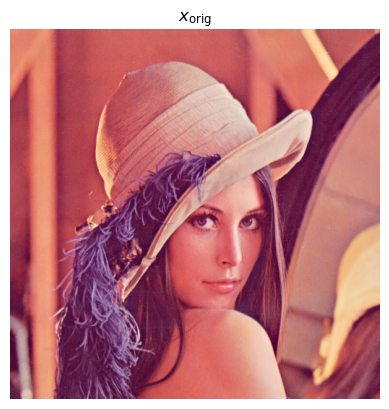

In [6]:
def imshow(x, ax=plt, **kargs):
    """
    Displays image x using pyplot.imshow.

    x: torch.Tensor (..., c, h, w) or (h, w) float32
    """
    assert x.dim() >= 2
    # (..., c, h, w)
    x = atleast_nd(x, 4)
    # (..., c, h, w) -> (b, c, h, w)
    x = rearrange(x, "... c h w -> (...) c h w")
    # pytorch to matplotlib conversion
    # (b, c, h, w) -> (b, h, w, c)
    x = rearrange(x, "b c h w -> b h w c")
    # vertical concatenation
    # (b, h, w, c) -> (bh, w, c)
    x = rearrange(x, "b h w c -> (b h) w c")
    ax.imshow(x, **kargs)

plt.figure()
plt.title("$x_{\mathrm{orig}}$")
plt.axis("off")
imshow(x_orig)

We need to have a comparison criterion that we would use after the denoising process. We will use two well known metric, peak-signal-noise-ratio (PSNR) and structural similarities (SSIM) as we mentioned it earlier. 

## Blurred image 
As we mention it at the beginning, we want to denoise an image that already blurred (we know what is the blur is) and then by adding random Gaussian noise, we will obtain the desired image that ready for denoising. So first, we define the blur kernel and convolution as in the following cell,   

In [7]:
# uniform blur kernel
blur_size = 10
blur_kernel = torch.ones((blur_size, blur_size))
blur_kernel *= 1/blur_kernel.numel()

def conv2d(x, kernel):
    """
    x: torch.Tensor(..., h, w)
    kernel: torch.Tensor(h_k, w_k)
    returns: torch.Tensor(..., h, w)
    """
    assert x.dim() >= 2
    assert kernel.dim() == 2
    # Remark: F.conv2d is (b, c_in, h, w) ->
    # (b, c_out, h, w) with kernel (c_out,
    # c_in, h_k, w_k)

    # save shape to undo grouping at the end
    shape = x.shape
    x = torch.atleast_3d(x)
    # group first dimensions
    x = rearrange(x, "... h w -> (...) h w")
    # add a dummy channel dimension
    x = rearrange(x, "b h w -> b 1 h w")
    # 1 channel in, 1 channel out
    kernel = repeat(kernel, "h w -> 1 1 h w")
    x = F.conv2d(x, kernel, padding="same")
    # ungroup first dimensions
    x = x.reshape(shape)
    return x

assert conv2d(x_orig, blur_kernel).shape == x_orig.shape
assert torch.equal(conv2d(x_orig, torch.tensor([[1.0]])), x_orig)

/var/folders/hr/s8vh2tdj11s6hjxcsw2lr01m0000gn/T/ipykernel_47660/3711708443.py:27: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1670284387925/work/aten/src/ATen/native/Convolution.cpp:896.)
  x = F.conv2d(x, kernel, padding="same")


The image is displayed after applying the $\phi$ function.

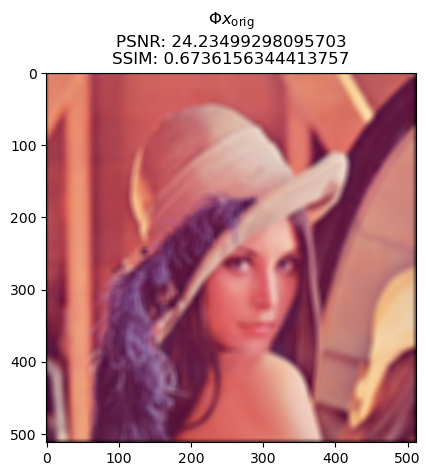

In [8]:
def phi(x):
    """
    Blur function.
    
    x: torch.Tensor(..., h, w)
    returns: torch.Tensor(..., h, w)
    """
    return conv2d(x, blur_kernel)
psnr = PeakSignalNoiseRatio()
psnr_phi = psnr(x_orig,phi(x_orig))
ssim_phi = ssim(x_orig,phi(x_orig))

plt.figure()
plt.title("$\Phi x_{\mathrm{orig}}$\n" + f"PSNR: {psnr_phi}\n"+f"SSIM: {ssim_phi}")
imshow(phi(x_orig))
plt.show()

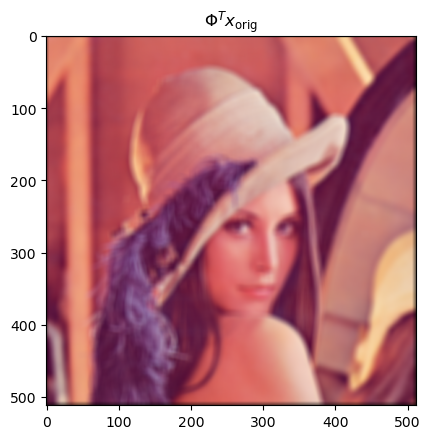

In [9]:
# transpose of convolution is (cross) correlation
def phi_transpose(x):
    K = torch.flip(blur_kernel, dims=(0,1))
    return conv2d(x, K)

x1 = torch.rand(x_orig.shape)
x2 = torch.rand(x_orig.shape)

assert phi(x1).shape == phi_transpose(x1).shape

# <x1, Phi x2>
dot1 = torch.dot(torch.flatten(x1), torch.flatten(phi(x2)))
# <Phi^T x1, x2>
dot2 = torch.dot(torch.flatten(phi_transpose(x1)), torch.flatten(x2))
# <x1, Phi x2> = <Phi^T x1, x2> up to numerical error
assert torch.abs(dot1 - dot2) < x1.numel() * 1e-4

plt.figure()
plt.title("$\Phi^T x_{\mathrm{orig}}$")
imshow(phi_transpose(x_orig))
plt.show()

## Adding noise 
We are adding random Gaussian noise i.e. $\varepsilon \sim N(0,I)$, to the blurred picture. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


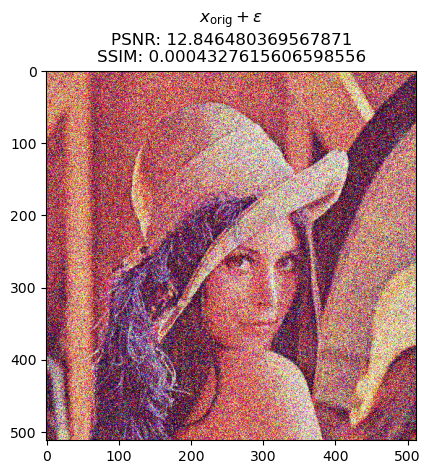

In [10]:
#sigma = 20 / 255
sigma = 0.1**0.5 
def epsilon(x, std=sigma):
    return torch.normal(0, sigma, x.shape)
psnr_noise = psnr(x_orig,epsilon(x_orig))
ssim_noise= ssim(x_orig,epsilon(x_orig))
plt.figure()
plt.title("$x_{\mathrm{orig}} + \epsilon$\n"+f"PSNR: {psnr_noise}\n" +f"SSIM: {ssim_noise}")
imshow(x_orig + epsilon(x_orig))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


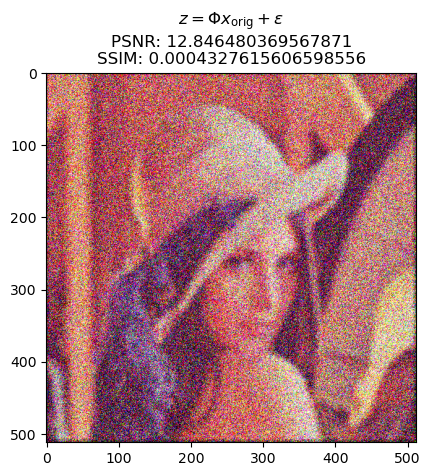

In [11]:
z = phi(x_orig) + epsilon(x_orig)
psnr_function = psnr(x_orig,epsilon(phi(x_orig)))
plt.figure()
plt.title("$z = \Phi x_{\mathrm{orig}} + \epsilon$\n"+f"PSNR: {psnr_noise}\n" +f"SSIM: {ssim_noise}")
imshow(z)
plt.show()

## Wavelet Transform 
A wavelet basis $ \mathbf{B} = \{ \psi_m \}_m $
is obtained over the continuous domain by translating and
dilating three mother wavelet functions $ \{\psi^V,\psi^H,\psi^D\} $.


Each wavelet atom is defined as
$$ \psi_m(x) = \psi_{j,n}^k(x) = \frac{1}{2^j}\psi^k\left( \frac{x-2^j n}{2^j} \right) $$

The scale (size of the support) is $2^j$ and the position is
$2^j(n_1,n_2)$. The index is $ m=(k,j,n) $ for $\{ j \leq 0 \}$.


The wavelet transform computes all the inner products
$ \{ \langle f,{\psi_{j,n}^k} \rangle\}_{k,j,n} $.

For the wavelet transform we need to fixed the max_level as in the following way.
**Note:**
***
We are using the `pytw` package for the wavelet transforms. 


In [12]:
# maximum wavelet level 
compute_max_level__memo = dict()
def compute_max_level(height, width):
    memo_key = (height, width)
    memo = compute_max_level__memo
    if memo_key not in memo:
        m = min(height, width)
        memo[memo_key] = int(np.floor(np.log2(m)))
    return memo[memo_key]

assert compute_max_level(1, 1) == 0
assert compute_max_level(2, 2) == 1
assert compute_max_level(4, 4) == 2
assert compute_max_level(8, 8) == 3
assert compute_max_level(8, 4) == 2
assert compute_max_level(4, 8) == 2
assert compute_max_level(9, 9) == 3

In [13]:
# utility function for Winv
compute_coeff_slices_memo = dict()
def compute_coeff_slices(height, width, wavelet="haar"):
    memo_key = (height, width, wavelet)
    if memo_key not in compute_coeff_slices_memo:
        x = np.empty((height, width))
        level = compute_max_level(height, width)
        wavelet_coeffs = pywt.wavedec2(x, wavelet, level=level)
        _, slices = pywt.coeffs_to_array(wavelet_coeffs)
        compute_coeff_slices_memo[memo_key] = slices
    return compute_coeff_slices_memo[memo_key]

height, width = 1000, 1000
assert len(compute_coeff_slices(height, width)) == compute_max_level(height, width) + 1

We need to be able to perform autograd on the wavelet transform to use the optimizer Adam provided by `pytorch`. The issue is that `pytorch` cannot compute the gradient of W because it is implemented using `pywt` which itself is based on `numpy`operators and not on `pytorch` operators. Thus we need to specify the gradient manually.

Also, you would see the wavelet transport of the image at the end.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


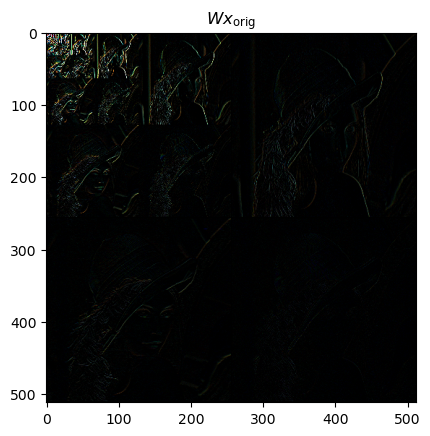

In [14]:
class WaveletAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, wavelet="haar"):
        """
        input: torch.Tensor (..., h, w)
        returns: torch.Tensor (..., h, w)
        """
        assert x.dim() >= 2
        # save shape to undo grouping at the end
        shape = x.shape
        torch.atleast_3d(x)
        # group first dimensions
        x = rearrange(x, "... h w -> (...) h w")
        # create output tensor
        out = torch.empty_like(x)
        
        b, height, width = x.shape
        level = compute_max_level(height, width)
        for k in range(b):
            image = x[k, :, :]
            # compute wavelet transform
            wavelet_coeffs = pywt.wavedec2(image, wavelet, level=level)
            wavelet_image, _ = pywt.coeffs_to_array(wavelet_coeffs)
            wavelet_image = torch.from_numpy(wavelet_image)
            # fill output tensor
            out[k, :, :] = wavelet_image

        # undo grouping
        out = out.reshape(shape)
        return out

    @staticmethod
    def backward(ctx, grad_out):
        # implemented bellow
        return Winv(grad_out)

W = WaveletAutograd.apply

plt.figure()
plt.title("$Wx_{\mathrm{orig}}$")
imshow(W(x_orig))
plt.show()

Inverse wavelet transform, also we need Autograd because of the same reason as before. Also, reader can see that the WaveletInverse is really the inverse by checking displayed picture here.  

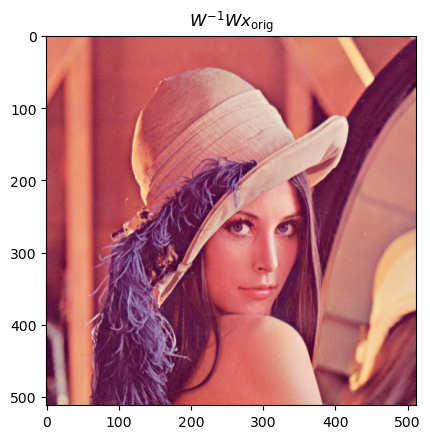

In [15]:
class WaveletInvAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, wavelet="haar"):
        """
        input: torch.Tensor (..., h, w)
        returns: torch.Tensor (..., h, w)
        """
        assert x.dim() >= 2
        shape = x.shape
        x = torch.atleast_3d(x)
        x = rearrange(x, "... h w -> (...) h w")
        out = torch.empty_like(x)
        
        b, height, width = x.shape
        level = compute_max_level(height, width)
        slices = compute_coeff_slices(height, width, wavelet)
        
        for k in range(b):
            wavelet_image = x[k, :, :]
            wavelet_coeffs = pywt.array_to_coeffs(wavelet_image, slices, output_format='wavedec2')
            image = pywt.waverec2(wavelet_coeffs, wavelet)
            image = torch.from_numpy(image)
            out[k, :, :] = image

        out = out.reshape(tuple(shape))
        return out

    @staticmethod
    def backward(ctx, grad_output):
        # implemented above
        return W(grad_output)

Winv = WaveletInvAutograd.apply

plt.figure()
plt.title("$W^{-1}Wx_{\mathrm{orig}}$")
imshow(Winv(W(x_orig)))
plt.show()

Define the loss here as the following, 

In [16]:
# 1/2||Phi x - z||_2^2 + lambda ||Wx||1
def loss_fn(x, z, lambd=1e-1):
    """
    x: torch.Tensor (..., c, h, w)
    z: torch.Tensor (..., c, h, w)
    lambd: float
    returns: float
    """
    assert x.shape == z.shape
    y = phi(x) - z
    Wx = W(x)
    
    # sum ~= 1e3
    data_fid_term = 1/2 * y ** 2
    # sum ~= 1e3 for lambd=1e-1
    regu_term = lambd * torch.abs(Wx)
    
    loss = data_fid_term + regu_term
    # we sum on channel, height and width
    loss = loss.sum(dim=(-1,-2,-3))
    # we mean over the remainding dimensions
    loss = loss.mean()
    
    return loss

# ~= 1e3 for lambd=1e-1
loss_fn(x_orig, z, lambd=.1)

tensor(42064.9414)

## Algorithm Adam 
Adam, an algorithm for first-order gradient-based optimization of
stochastic objective functions, based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient,
has little memory requirements, is invariant to diagonal rescaling of the gradients,
and is well suited for problems that are large in terms of data and/or parameters. We will use the results of Adam (PSNR and SSIM) to have a comparison with results in Conda-Vu algorithm.  


First, implementation of Adam, with the loss function.



In [17]:
from tqdm import tqdm

def optim_adam(z, lambd=1e-1, lr=1, min_epochs=10, max_epochs=10, eps=1e-4):
    x = z.detach().clone()
    x.requires_grad_(True)
    
    losses = [loss_fn(x, z, lambd=lambd).detach().clone()]

    optimizer = torch.optim.Adam([ x ], lr=lr)
    for epoch in tqdm(range(max_epochs)):
        # convergence condition
        if epoch >= min_epochs and len(losses) >= 2 and torch.abs((losses[-1] - losses[-2]) / losses[-2]) < eps:
            break
        loss = loss_fn(x, z, lambd=lambd)
        optimizer.zero_grad()
        losses.append(loss.detach().clone())
        loss.backward()
        optimizer.step()
    
    losses = torch.tensor(losses)
    
    return x, losses

epochs = 1
x_adam, losses = optim_adam(z, max_epochs=epochs)

assert x_adam.shape == z.shape
assert len(losses) == epochs+1

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


We want to keep relevant values in memory in order to avoid to compute them multiple times while working on the code.
**Note:**
***
Don't forget to reset following cell every time to calculate adam, to reset inside values.

In [18]:
# state[lambd] = (epoch, losses, x)
state_adam = dict()
state = state_adam

Here we are computing the results, comparing different $\lambda$ values according to their PSNR values.

In [19]:
state_adam = dict()
state = state_adam

# Comparison using different values for lambd to pick a good default value

max_epochs = 100
lr = 1e-2
eps = 1e-5

#lambd_list = [ (i)*1e-1 for i in range(1,11) ]
#lambd_list = [ (i+1)*1e-2 for i in range(30) ]
lambd_linspace = torch.linspace(9e-2,25e-2,15)
lambd_list = lambd_linspace.flatten().tolist()

N = len(lambd_list)
# To catch the calue of lambda that give the best PSNR value
peak = lambd_list[0]
for lambd in lambd_list:
    # prevent recomputations
    if lambd in state:
        continue

    x_adam, losses = optim_adam(z, lambd=lambd, lr=lr, max_epochs=max_epochs, eps=eps)
    psnr_adam = psnr(x_orig,x_adam)
    peak_adam, _ = optim_adam(z, lambd=peak, lr=lr, max_epochs=max_epochs, eps=eps)
    if psnr(x_orig,x_adam) > psnr(x_orig,peak_adam):
        peak = lambd

    state[lambd] = (epochs, losses,psnr_adam.detach().clone(), x_adam.detach().clone())


100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


Display the loss functions, with different $\lambda$ values that we calculated above. 

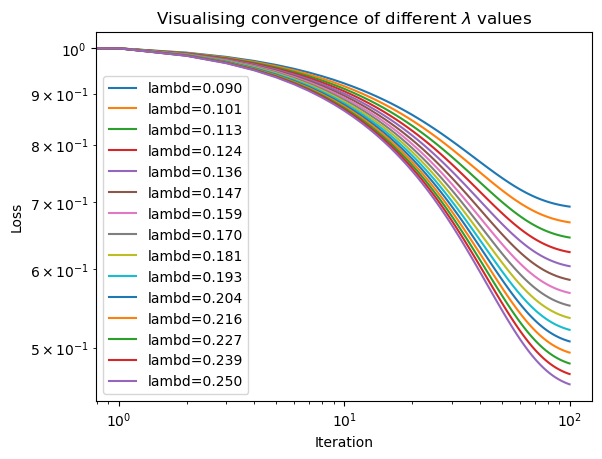

In [20]:
plt.figure()
plt.title("Visualising convergence of different $\lambda$ values")

# display loss
for lambd in lambd_list:
    _,losses, _, _ = state[lambd]
    # we rescale the loss to compare for different values of lambd
    losses = losses / losses[0]
    plt.loglog(losses, label=f"lambd={lambd:.3f}")

plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend()
plt.show()

#### PSNR 
Here we are plotting the PSNR/$\lambda$ graph, on the interval of $\lambda$. It will help us to choose appropriate value of $\lambda$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


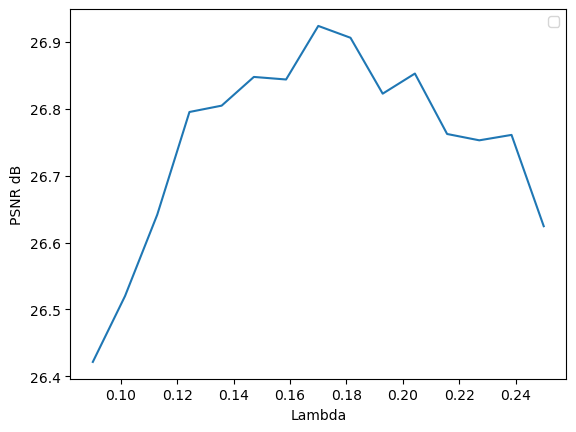

In [21]:
pts_x = []
pts_y = []

for lambd in lambd_list:
    _, _, psnr_adam , _ = state[lambd]
    pts_x.append(lambd)
    pts_y.append(psnr_adam)

plt.plot(pts_x, pts_y)
plt.ylabel("PSNR dB")
plt.xlabel("Lambda")
plt.legend()
plt.show()

Here is the figure representation of different of $\lambda$.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

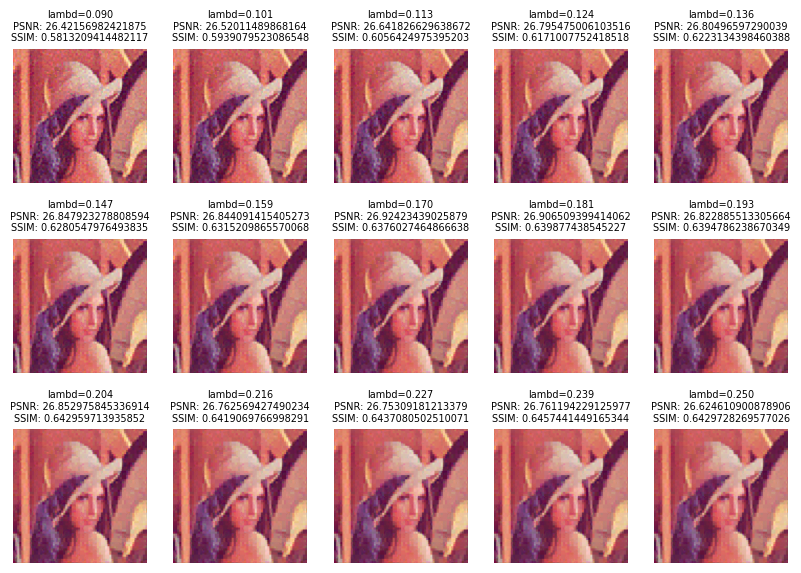

In [22]:
fig = plt.figure(figsize = (10,7))
k = 0
for lambd in lambd_list:
    _, _, _,x_adam = state[lambd]
    k += 1
    fig.add_subplot(3, 5, k)
    plt.title(f"lambd={lambd:.3f}\n"+f"PSNR: {psnr(x_orig,x_adam)}\n"+f"SSIM: {ssim(x_orig,x_adam)}",fontsize = 7)
    plt.axis('off')
    imshow(x_adam)
plt.show()

#### Comparison of the result with $z$
Choose the $\lambda$ as the one gives the best PSNR result. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


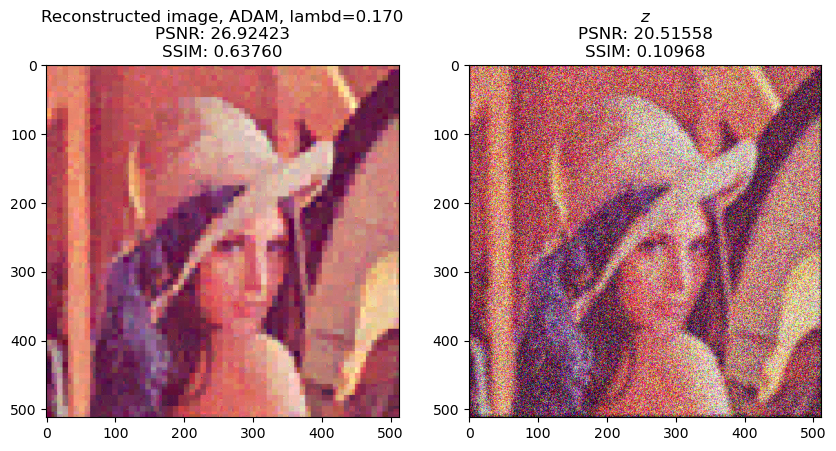

In [23]:
lambd = peak
_, _, _, x_adam = state[lambd]

fig = plt.figure(figsize = (10,7))
fig.add_subplot(1,2,1)
imshow(x_adam)
plt.title(f"Reconstructed image, ADAM, lambd={lambd:.3f}\n"+f"PSNR: {psnr(x_orig,x_adam):.5f}\n" +f"SSIM: {ssim(x_orig,x_adam):.5f}" )
fig.add_subplot(1,2,2)
imshow(z)
plt.title("$z$\n"+f"PSNR: {psnr(x_orig,z):.5f}\n" +f"SSIM: {ssim(x_orig,z):.5f}" )
plt.show()

**Remark:**
***
To have a comparability, we need to choose same $\lambda$ values for the both algorithm. 

In [24]:
def nabla_f(x, z):
    return phi_transpose(phi(x) - z)

assert nabla_f(x_orig, z).shape == x_orig.shape

In [25]:
def W_star(x):
    return Winv(x)

assert W_star(x_orig).shape == x_orig.shape

L = W
L_star = W_star

## Algorithm: Conda - Vu (Douglas-Rachford )
Recall the general frame work of the minimization problem at the beginning, $\text{argmin}_{x \in \mathbb{R}^N} f(x)+h(x) + (g \circ L)(x)$. For our specific case, the version of the algorithm that we will use is the following:
$$
(\forall n \in \mathbb{N})  \begin{cases} 
& p_{n} =  \text{prox}_{\tau f}(x_n -\tau (\nabla h(n_n) + L^{*}v_n) \\ & q_{n} =   \text{prox}_{\sigma g^*}(v_n + \sigma( L (2p_n - x_n) )) \\ &
(x_{n+1},v_{n+1}) =  (x_n,v_n) + \lambda_n((p_n,q_n)-(x_n,v_n))
\end{cases}
$$
where the case $h(x) = 0$. 
First, let's start with implementing the proximal operators.

### Proximal Operator 
As we mention at the introduction, we know what is the proximal operator of $g = ||\cdot||_1$


In [26]:
def prox_L1(x, tau):
    return (x < -tau) * (x + tau) + (x > tau) * (x - tau)

In this point to calculate $g^*$, we want to use Moreu's identity as in the following form, 
$$
v = \text{prox}_{\lambda g}(v) + \lambda \text{prox}_{\lambda^{-1} g^*}(x/\tau)
$$

In [27]:
def prox_g_star(x, tau, lambd):
    # moreau identity
    return x - tau * prox_L1(x / tau, lambd * 1/tau)

assert prox_g_star(x_orig,1, lambd).shape == x_orig.shape

In [28]:
x = torch.rand_like(x_orig)
x /= torch.norm(torch.flatten(x))
torch.norm(torch.flatten(phi_transpose(phi(x))))

tensor(0.8552)

Here is the implementation of the Conda-Vu algorithm

In [29]:
def optim_condat_vu(z, tau1=1e-3, lambd=1e-1, min_epochs=10, max_epochs=100, eps=1e-4):
    x = z.detach().clone()
    y = z.detach().clone()

    losses = [loss_fn(x, z, lambd=lambd).detach().clone()]
    
    # rho must be between 0 and something within [1,2]
    rho = 1 - 1e-1
    # 1/tau1 - tau2 >= xi / 2
    # xi <= 1 so we can use
    # 1/tau1 - tau2 >= 1/2
    # tau2 <= 1/tau1 - 1/2
    # tau2 = 0.9(1/tau1 - 1/2)
    # 0.9 is for relaxation
    tau2 = 0.9 * (1 / tau1 - 1/2)

    for epoch in tqdm(range(max_epochs)):
        u = x - tau1 * (nabla_f(x, z) + L_star(y))
        v = prox_g_star(y + tau2 * L(2 * u - x), tau=tau2, lambd=lambd)
        x_next = rho * u + (1 - rho) * x
        y_next = rho * v + (1 - rho) * y
        x, y = x_next, y_next
        
        loss = loss_fn(x, z, lambd=lambd)
        losses.append(loss.detach().clone())
    
    losses = torch.tensor(losses)
    
    return x, losses

Like in the Adam algorithm, we want to slip off of doing multiple computations. 
**Note:**
***
Next cell should be run it every time to clear what it was had. 

In [30]:
condat_vu_state = dict()
state = condat_vu_state

#### Loss Function
Here we plot the loss function of Conda-Vu to check the convergence of the lost function visually. 

100%|█████████████████████████████████████████| 400/400 [01:28<00:00,  4.54it/s]


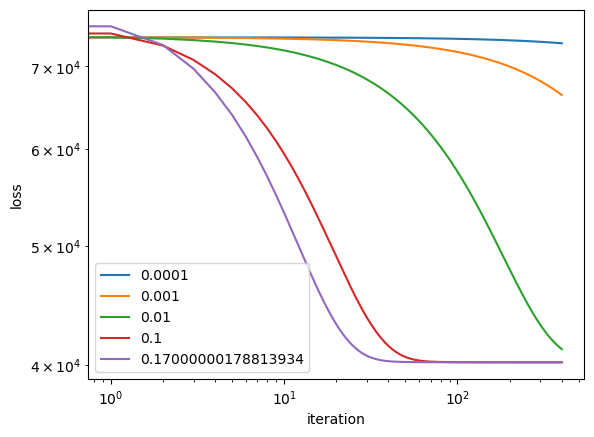

In [31]:
max_epochs = 400
eps = 1e-5

# try multiple values to see what's happening

tau1_values = [ 1e-4, 1e-3, 1e-2, 1e-1, lambd]


for tau1 in tau1_values:
    if tau1 in state:
        continue
    x, losses = optim_condat_vu(z, tau1=tau1, lambd=lambd, max_epochs=max_epochs, eps=eps)
    state[tau1] = (x, losses)

plt.figure()

for tau1 in tau1_values:
    _, losses = state[tau1]
    plt.loglog(losses, label=f"{tau1}")

plt.ylabel("loss")
plt.xlabel("iteration")
plt.legend()
plt.show()

Before showing the last result, here we compute the requested measurements,  

In [32]:
psnr_conda = psnr(x_orig,x)
ssim_x = ssim(x_orig,x)
psnr_z = psnr(x_orig,z)
ssim_z = ssim(x_orig,z)

#### Comparison of the result with $z$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


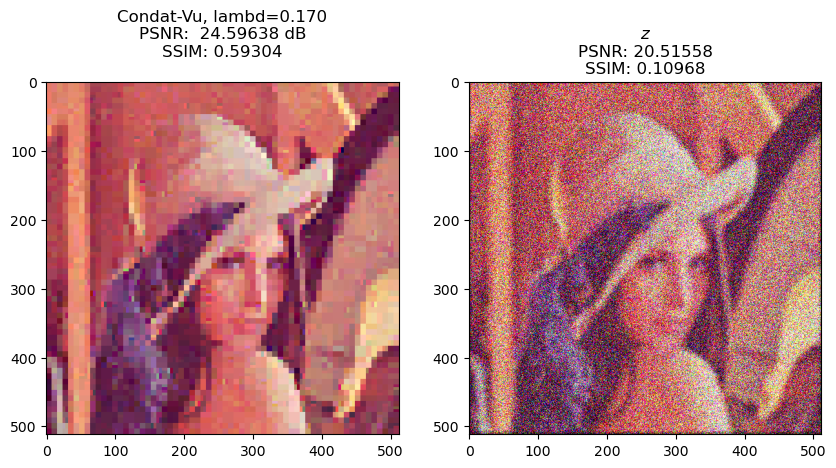

In [33]:
fig = plt.figure(figsize=(10,7))

fig.add_subplot(1,2,1)
imshow(x)
plt.title(f"Condat-Vu, lambd={lambd:.3f}\n"+f"PSNR:  {psnr_conda:.5f} dB\n"+f"SSIM: {ssim_x:.5f}\n")

fig.add_subplot(1,2,2)
imshow(z)
plt.title("$z$\n"+f"PSNR: {psnr(x_orig,z):.5f}\n" +f"SSIM: {ssim(x_orig,z):.5f}" )

plt.show()

# Conclusion
Until this point we have done the followings:
1. We processed the original image by taking the convolution with blur kernel, and adding random Gaussian noise, to obtain the $z$.
2. Wavelet transform introduced, which is one of the well-known transformations in signal processing. We introduced the `Autograd` function of wavelet transform because of the tensor requirements of `PyTorch` (the `pywt` package was written in `NumPy`). 
3. We implemented our version of Adam by using the `torch.optim.Adam`, the part of our implementation was done to have hyper-parameters that we need in the whole process.
4. Different $\lambda$ values were compared with respect to their's resulting images' PSNR values. In our finite dimensional subset, we choose the best value which gives the best PSNR. 5. Proximal operator was implemented, in a way that we can use with our environment. 
6. Conda-Vu implemented.
7. To have comparable results, we used the same $\lambda$ value, and we compare different $\tau$ values. $\lambda$ gave the best results.

Under these specific condition, Adam algorithm give us the best PSNR and SSIM values, as it can be seen in the following:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


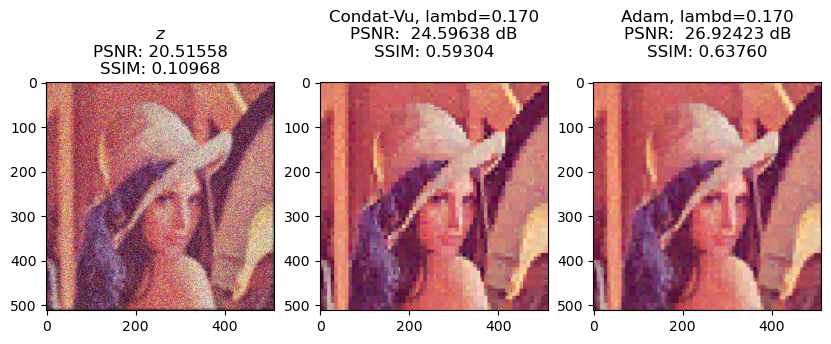

In [34]:
fig = plt.figure(figsize=(10,7))

fig.add_subplot(1,3,1)
imshow(z)
plt.title("$z$\n"+f"PSNR: {psnr(x_orig,z):.5f}\n" +f"SSIM: {ssim(x_orig,z):.5f}" )

fig.add_subplot(1,3,2)
imshow(x)
plt.title(f"Condat-Vu, lambd={lambd:.3f}\n"+f"PSNR:  {psnr_conda:.5f} dB\n"+f"SSIM: {ssim_x:.5f}\n")

fig.add_subplot(1,3,3)
imshow(x_adam)
plt.title(f"Adam, lambd={lambd:.3f}\n"+f"PSNR:  {psnr(x_orig,x_adam):.5f} dB\n"+f"SSIM: {ssim(x_orig,x_adam):.5f}\n")


plt.show()